<a href="https://colab.research.google.com/github/ioloi1128/IPCS1121_HW/blob/main/IPCS1121_Heatwave_HW2_SelectHeatwave90p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IPCS Heatwave HW2:

Calculate the PR90 value, select the value excess PR90

Level 1: Choose the location from your HW1
Compare the total heatwave days between 1980-1990 and 2010-2020

Level 2: Follow Level 1
Compare the total heatwave intensity between 1980-1990 and 2010-2020

Level 3: Add the window of 15 days then repeat level 1 and 2


In [ ]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

!pip install cartopy
import cartopy.crs as ccrs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
#Download ERA5 Tmax, 1979-2022, land only
#https://drive.google.com/file/d/1DxdTnEnsk1VfgVUdfnBjulQNFgdcKe_Q/view?usp=sharing
!gdown 1DxdTnEnsk1VfgVUdfnBjulQNFgdcKe_Q

Downloading...
From: https://drive.google.com/uc?id=1DxdTnEnsk1VfgVUdfnBjulQNFgdcKe_Q
To: /content/ERA5_SFC_mx2t_1979-2022_r144x73_day.land.nc
100% 676M/676M [00:08<00:00, 78.7MB/s]


In [ ]:
filename ='ERA5_SFC_mx2t_1979-2022_r144x73_day.land.nc'
ds_mx2t = xr.open_dataset(filename)


In [ ]:
# Convert Kelvin to Celsius
ds_mx2t = ds_mx2t - 273.15

In [ ]:
ds_mx2t['time'] = ds_mx2t['time'].astype('datetime64[ns]')
print(ds_mx2t['time'].dtype)
print(ds_mx2t['time'])

start_date = np.datetime64('1979-01-01')
end_date = np.datetime64('2023-01-01')  # Adjust the end date as needed

# Create a time array with intervals of 1 day
time_array = np.arange(start_date, end_date, np.timedelta64(1, 'D'))

print(time_array)
ds_mx2t['time'] = time_array

datetime64[ns]
<xarray.DataArray 'time' (time: 16071)>
array(['1970-01-01T00:00:00.019790101', '1970-01-01T00:00:00.019790102',
       '1970-01-01T00:00:00.019790103', ..., '1970-01-01T00:00:00.020221229',
       '1970-01-01T00:00:00.020221230', '1970-01-01T00:00:00.020221231'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T00:00:00.019790101 ... 1970-01-...
Attributes:
    standard_name:  time
    long_name:      Date
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T
['1979-01-01' '1979-01-02' '1979-01-03' ... '2022-12-29' '2022-12-30'
 '2022-12-31']


In [ ]:
# check the data size
mx2t=ds_mx2t['mx2t']
print(mx2t.shape)
#print(mx2t.values)

(16071, 73, 144)


In [ ]:
data_365dy = mx2t.groupby('time.dayofyear').quantile(0.9)
print(data_365dy.shape)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


(366, 73, 144)


In [ ]:
# mask the data with
t2m_anom = mx2t.groupby('time.dayofyear') - data_365dy
print(t2m_anom.shape)
mask_90p = np.zeros_like(t2m_anom)
mask_90p[np.where(t2m_anom>0)] = 1
mx2t.values = mask_90p

(16071, 73, 144)


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


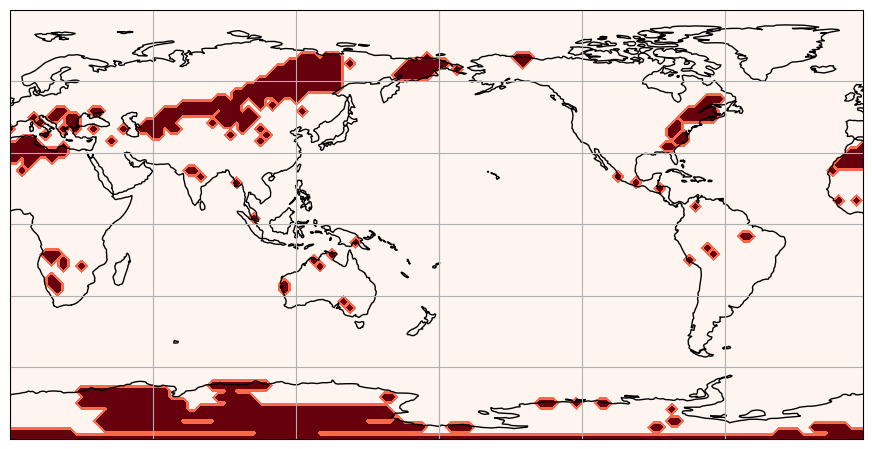

In [ ]:
# Plot out the mask for 1979-01-01
hw_index_yr = mx2t.sel(time=slice("1979-01-01", "1979-01-01"))
# plot the geospatial distribution of
#import cartopy.crs as ccrs
#import cartopy.mpl.ticker as cticker
#from cartopy.util import add_cyclic_point

clevs=np.arange(0,1,0.5)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))


# Add cyclic point
#hw_index_yr,lon=add_cyclic_point(hw_index_yr,coord=hw_index_yr['lon'])

# Make a filled contour plot
cs=ax.contourf(hw_index_yr['lon'],hw_index_yr['lat'],
            hw_index_yr[0,:,:],clevs,
            transform=ccrs.PlateCarree(),
            cmap='Reds',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

In [ ]:
#select summer (JJA) only
mx2t_jja = mx2t.sel(time=mx2t.time.dt.month.isin([6, 7, 8]))

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
